# Identifying SRKW Orca Calls using CNN and SNN
## 03-Use SNN to identify SRKW calls

Import libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import os
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

from pylab import *

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from scipy import spatial

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, BatchNormalization, Concatenate, Layer, MaxPooling2D
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.initializers import glorot_uniform,he_uniform

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model,normalize


2022-08-25 21:23:47.486027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
%matplotlib inline
np.random.seed(0)

Define directories

In [3]:
parentdir="../"
codedir=parentdir+"code/"
datadir=parentdir+"data/"
train_dir=datadir+"TrainDataLatest_PodCastAllRounds_123567910/"
test_dir=datadir+"TestDataLatest_PodCastAllRounds_123/"
output=parentdir+"output/"
specdir=output+"spectrogram/"
specdir_train=specdir+"train/all/"
specdir_test=specdir+"test/all/"
model_dir = output + 'model/'


In [4]:
directory_filenames_train_pos = glob.glob(specdir_train + '*_pos.png')
directory_filenames_train_neg = glob.glob(specdir_train + '*_neg.png')
directory_filenames_test_pos = glob.glob(specdir_test + '*_pos.png')
directory_filenames_test_neg = glob.glob(specdir_test + '*_neg.png')

 Read in training spectrograms and create training data

In [5]:
spectrogram_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_pos)):
    img=cv2.imread(directory_filenames_train_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spectrogram_pos.append(img)
spectrogram_pos=np.asarray(spectrogram_pos, dtype=object)
del(i, img)

In [6]:
spectrogram_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_neg)):
    img=cv2.imread(directory_filenames_train_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spectrogram_neg.append(img)
spectrogram_neg=np.asarray(spectrogram_neg, dtype=object)
del(i, img)

In [7]:
index_pos=list(range(len(directory_filenames_train_pos)))
index_neg=list(range(len(directory_filenames_train_neg)))
listpos=np.full((len(directory_filenames_train_pos),1), 1.0)
listneg=np.full((len(directory_filenames_train_neg),1), 0.0)

In [8]:
# Split up the training data into 80% train and 20% validation. 
# There is a set aside testing data that we will not use in the training.  
X_pos_train, X_pos_validation, y_pos_train, y_pos_validation, index_pos_train, index_pos_validation = train_test_split(spectrogram_pos, listpos, index_pos, test_size=0.2, random_state=76)
X_neg_train, X_neg_validation, y_neg_train, y_neg_validation, index_neg_train, index_neg_validation = train_test_split(spectrogram_neg, listneg, index_neg, test_size=0.2, random_state=76)

In [9]:
x_train=np.concatenate([X_pos_train, X_neg_train])
y_train=np.concatenate([y_pos_train, y_neg_train])
x_validation=np.concatenate([X_pos_validation, X_neg_validation])
y_validation=np.concatenate([y_pos_validation, y_neg_validation])
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(4329, 224, 224, 3)
(4329, 1)
(1084, 224, 224, 3)
(1084, 1)


Read in testing spectrograms and create testing data

In [10]:
spect_test_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_pos)):
    img=cv2.imread(directory_filenames_test_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_pos.append(img)
spect_test_pos=np.asarray(spect_test_pos, dtype=object)
del(i, img)

In [11]:
spect_test_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_neg)):
    img=cv2.imread(directory_filenames_test_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_neg.append(img)
spect_test_neg=np.asarray(spect_test_neg, dtype=object)
del(i, img)

In [12]:
index_test_pos=list(range(len(directory_filenames_test_pos)))
index_test_neg=list(range(len(directory_filenames_test_neg)))
listtestpos=np.full((len(directory_filenames_test_pos),1), 1.0)
listtestneg=np.full((len(directory_filenames_test_neg),1), 0.0)

In [13]:
x_test=np.concatenate([spect_test_pos, spect_test_neg])
y_test=np.concatenate([listtestpos, listtestneg])
print(x_test.shape)
print(y_test.shape)

(809, 224, 224, 3)
(809, 1)


Helper functions to create triplets

In [14]:
species_id_list = [1,0]

In [15]:
def get_image(label):
    y = y_train
    x = x_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        idx = np.random.randint(len(y))
    return x[idx]
    
def get_triplet():
    anchor_class = 1
    negative_class = 0
    a, p = get_image(anchor_class), get_image(anchor_class)
    n = get_image(negative_class)
    return a, p, n

def generate_hard_triplets(batch_size = 5, hard_batchs_size = 2):
    while True:
        list_a_random = []
        list_p_random = []
        list_n_random = []

        for i in range(batch_size):
            a, p, n = get_triplet()
            list_a_random.append(a)
            list_p_random.append(p)
            list_n_random.append(n)
            
        A_random = np.array(list_a_random, dtype='float32')
        P_random = np.array(list_p_random, dtype='float32')
        N_random = np.array(list_n_random, dtype='float32')
        
        A_random_embedding = branch_model.predict(A_random)
        P_random_embedding = branch_model.predict(P_random)
        N_random_embedding = branch_model.predict(N_random)
        
        studybatchloss = np.sum(np.square(A_random_embedding - P_random_embedding),axis=1) - np.sum(np.square(A_random_embedding - N_random_embedding),axis=1)

        hard_examples = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
        A_hard = A_random[hard_examples]
        P_hard = P_random[hard_examples]
        N_hard = N_random[hard_examples]
        
        list_a_new = []
        list_p_new = []
        list_n_new = []
        
        for i in range(batch_size - hard_batchs_size):
            a, p, n = get_triplet()
            list_a_new.append(a)
            list_p_new.append(p)
            list_n_new.append(n)
            
        A_new = np.array(list_a_new, dtype='float32')
        P_new = np.array(list_p_new, dtype='float32')
        N_new = np.array(list_n_new, dtype='float32')
        
        A = np.concatenate((A_hard, A_new), axis=0)
        P = np.concatenate((P_hard, P_new), axis=0)
        N = np.concatenate((N_hard, N_new), axis=0)

        label = np.ones(batch_size)
        yield [A, P, N], label

In [16]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.1):
    anchor,positive,negative = x
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def get_branch_model(inp_shape):
    model = DenseNet201(input_shape=inp_shape, include_top=False, weights=None, pooling='max')
    return model

def head_model(input_shape, branch_model):
    input_1 = Input(input_shape)
    input_2 = Input(input_shape)
    input_3 = Input(input_shape)
        
    A = branch_model(input_1)
    P = branch_model(input_2)
    N = branch_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    #optimizer = Adam(lr = 0.0001, decay = 10e-6)
    optimizer = Adam()
    model.compile(loss=identity_loss, optimizer=optimizer)
    return model

In [17]:
img_rows, img_cols, n_channels = 224, 224, 3
input_shape = (img_rows, img_cols, n_channels)

In [18]:
branch_model = get_branch_model(input_shape)

train_generator = generate_hard_triplets()
batch = next(train_generator)

model = head_model(input_shape, branch_model)
model.summary()

2022-08-25 21:31:02.504944: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-25 21:31:02.722523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-25 21:31:03.137992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-08-25 21:31:03.138057: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-25 21:31:03.879017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-25 21:31:03.879139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-25

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 1920)         18321984    input_2[0][0]                    
                                                                 input_3[0][0]                

In [19]:
featured_img = branch_model.predict(np.ones((1,img_rows,img_cols,n_channels)))
print('length of vector representation for image:',len(featured_img[0]))
print(featured_img)

length of vector representation for image: 1920
[[0.03079385 0.05224643 0.10428659 ... 0.04396043 0.01635477 0.05069489]]


In [20]:
history = model.fit_generator(train_generator, 
                              epochs=50, 
                              verbose=1,
                              steps_per_epoch=500
                             )

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 2543s 1s/step - loss: 62.3720
Epoch 2/50
500/500 [==============================] - 686s 1s/step - loss: 0.8765
Epoch 3/50
500/500 [==============================] - 685s 1s/step - loss: 0.5218
Epoch 4/50
500/500 [==============================] - 685s 1s/step - loss: 0.0176
Epoch 5/50
500/500 [==============================] - 684s 1s/step - loss: 0.0127
Epoch 6/50
500/500 [==============================] - 685s 1s/step - loss: 0.0162
Epoch 7/50
500/500 [==============================] - 685s 1

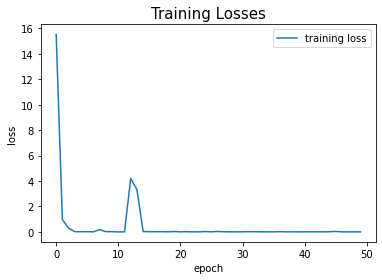

In [21]:
plt.plot(history.history['loss'])
plt.title('Training Losses',size = 15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss'], loc='upper right')
plt.show()

In [22]:
x_train=x_train.astype('float32')
y_train=y_train.astype('float32')
x_validation=x_validation.astype('float32')
y_validation=y_validation.astype('float32')
x_test=x_test.astype('float32')
y_test=y_test.astype('float32')

In [23]:
x_train_embedding = branch_model.predict(x_train)
x_test_embedding = branch_model.predict(x_test)

tsne = TSNE(n_components=2, random_state= 4)
train_tsne_embeds = tsne.fit_transform(x_train_embedding)
test_tsne_embeds = tsne.fit_transform(x_test_embedding)

2022-08-26 08:11:00.713976: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2606542848 exceeds 10% of free system memory.
2022-08-26 08:50:20.024081: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 487108608 exceeds 10% of free system memory.


In [24]:
y_train_labels=['Positive Call' if v==1 else 'Negative Call' for v in y_train.reshape(y_train.shape[0],)]

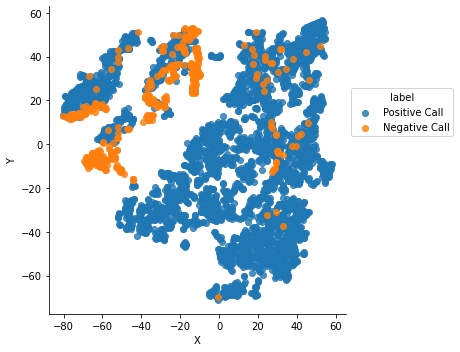

In [25]:
scatterDF =  pd.DataFrame(
    {'X': train_tsne_embeds[:,0],
     'Y': train_tsne_embeds[:,1],
     'Label': y_train_labels
    })

scatter_plot = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', fit_reg=False, legend=False)

legend = scatter_plot.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(legend.get_texts()):
    plt.setp(text,color = 'black')

In [26]:
y_test_labels=['Positive Call' if v==1 else 'Negative Call' for v in y_test.reshape(y_test.shape[0],)]

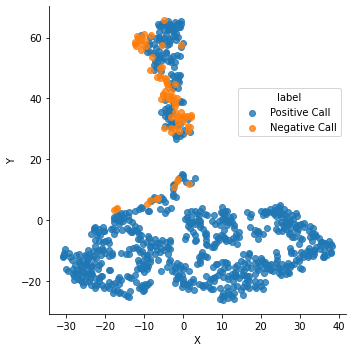

In [27]:
scatterDF =  pd.DataFrame(
    {'X': test_tsne_embeds[:,0],
     'Y': test_tsne_embeds[:,1],
     'Label': y_test_labels
    })

scatter_plot = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', fit_reg=False, legend=False)
legend = scatter_plot.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(legend.get_texts()):
    plt.setp(text,color = 'black')

In [28]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

branch_model.save_weights(model_dir + 'weights_classification_siamese_network_50epoch.h5')

Build classification model

In [29]:
spectrogram_filenames_test = directory_filenames_test_pos + directory_filenames_test_neg
print(len(directory_filenames_test_neg), len(directory_filenames_test_pos), len(spectrogram_filenames_test))

78 731 809


In [30]:
def dist_diff_square(a,b):
    return np.sum(np.square(a-b))

def pred(k_nearest_neighbors):
    pred_test = pd.DataFrame()
    pred_test['spectrogram_filename'] = [spectrogram_filename.split('/')[-1] for spectrogram_filename in spectrogram_filenames_test]
    pred_test['true_species_id'] = y_test
    pred_test['pred_species_id'] = None
    pred_test['pred_correct'] = 0
    for i in range(len(pred_test)):
        distance_with_each_species = []
        for species_id in species_id_list:
            species_id_train_index = [index for index, x in enumerate(y_train) if x == species_id]
            x_train_embedding_species_id = x_train_embedding[species_id_train_index]
            embedding_distance_species_id = [dist_diff_square(x_test_embedding[i], embedding) for embedding in x_train_embedding_species_id] 
            k_nearest_neighbors_species_id = sort(embedding_distance_species_id)[:k_nearest_neighbors]
            distance_with_each_species.append(mean(k_nearest_neighbors_species_id))
        most_similar_species_sorted = [species_id_list[i] for i in np.argsort(distance_with_each_species)]
        pred_test.at[i,'pred_species_id'] = most_similar_species_sorted[0]
        pred_test.at[i, 'pred_correct'] = int(y_test[i]==most_similar_species_sorted[0])
    return pred_test

In [31]:
pred_test_1_neighbor = pred(k_nearest_neighbors = 1)
pred_test_3_neighbor = pred(k_nearest_neighbors = 3)
pred_test_5_neighbor = pred(k_nearest_neighbors = 5)
pred_test_10_neighbor = pred(k_nearest_neighbors = 10)

print('accuracy for test set with closest 1 neighbor: ', "{0:.2%}".format(sum(pred_test_1_neighbor.pred_correct) / len(pred_test_1_neighbor)))
print('accuracy for test set with closest 3 neighbors: ', "{0:.2%}".format(sum(pred_test_3_neighbor.pred_correct) / len(pred_test_3_neighbor)))
print('accuracy for test set with closest 5 neighbors: ', "{0:.2%}".format(sum(pred_test_5_neighbor.pred_correct) / len(pred_test_5_neighbor)))
print('accuracy for test set with closest 10 neighbors: ', "{0:.2%}".format(sum(pred_test_10_neighbor.pred_correct) / len(pred_test_10_neighbor)))

accuracy for test set with closest 1 neighbor:  91.97%
accuracy for test set with closest 3 neighbors:  92.83%
accuracy for test set with closest 5 neighbors:  92.95%
accuracy for test set with closest 10 neighbors:  93.20%


In [32]:
pred_test_1_neighbor.to_csv(output+'snn50e_pred1neighbor.csv', index=False)
pred_test_3_neighbor.to_csv(output+'snn50e_pred3neighbor.csv', index=False)
pred_test_5_neighbor.to_csv(output+'snn50e_pred5neighbor.csv', index=False)
pred_test_10_neighbor.to_csv(output+'snn50e_pred10neighbor.csv', index=False)

In [33]:
confusion_matrix = pd.crosstab(pred_test_10_neighbor['true_species_id'], pred_test_10_neighbor['pred_species_id'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0    1
Actual            
0.0        24   54
1.0         1  730
